In [1]:
import geopandas as gpd
import pandas as pd
import json
import xarray as xr

import odp
import geopandas as gpd
import pandas as pd
import matplotlib.dates as md
import dateutil
import numpy as np


import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import cmocean

import matplotlib.cm as cm
from math import pi
import os
import warnings
warnings.filterwarnings("ignore")
import azure.storage.blob 
import zarr


Necessary code to connect to storage in database

In [2]:
blob_service_client=azure.storage.blob.BlobServiceClient.from_connection_string(os.environ['ODE_CONNECTION_STR'])

In [3]:
container_client = blob_service_client.get_container_client('crw')

In [4]:
container='crw'
folder='zarr/'

### Pulling the data

In [5]:
file_list = list(set([b.name for b in container_client.walk_blobs(folder, delimiter='/')  ]))
file_list.sort()

In [6]:
store_list=[]
for year in range(1985,2023):
    result = list(filter(lambda x: "_"+str(year)+"_" in x, file_list))
    for file in result:
            store=zarr.ABSStore(prefix=file,client=container_client)
            store_list.append(store)
data=xr.open_mfdataset(store_list, parallel=True, engine='zarr')

In [7]:
data

<xarray.Dataset>
Dimensions:           (time: 13603, lat: 3600, lon: 7200)
Coordinates:
  * lat               (lat) float32 -89.97 -89.93 -89.88 ... 89.88 89.93 89.97
  * lon               (lon) float32 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * time              (time) datetime64[ns] 1985-01-01T12:00:00 ... 2022-03-3...
Data variables:
    analysed_sst      (time, lat, lon) float32 dask.array<chunksize=(1, 450, 900), meta=np.ndarray>
    crs               (time) int16 dask.array<chunksize=(31,), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float32 dask.array<chunksize=(1, 450, 1800), meta=np.ndarray>
Attributes: (12/58)
    Conventions:                CF-1.6, ACDD-1.3
    acknowledgement:            NOAA Coral Reef Watch Program
    cdm_data_type:              Grid
    comment:                    This product is designed to improve on and re...
    contributor_name:           NOAA Coral Reef Watch Program
    contributor_role:           Collecting source data and deriving products;...
    ...                         ...
    time_coverage_duration:     P1D
    time_coverage_end:          19850102T000000Z
    time_coverage_resolution:   P1D
    time_coverage_start:        19850101T000000Z
    title:                      NOAA Coral Reef Watch Daily Global 5km Satell...
    uuid:                       36c339e6-c901-11e7-8a08-38d54702cff0

### Import the polygon of Florida and Northern Caribbean using geopandas

In [8]:
poly = gpd.read_file('boundary.geojson')
poly.head()

,name,geometry
0,"Northern Caribbean, Florida, & Bahamas","MULTIPOLYGON (((-83.74803 29.79798, -83.76670 ..."


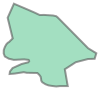

In [9]:
poly['geometry'][0]

### Figure out the bounding box for our area of interest

In [10]:
coords = list(poly["geometry"][0].envelope.exterior.coords)
coords

[(-85.55076, 15.961632),
 (-70.021079, 15.961632),
 (-70.021079, 29.840357),
 (-85.55076, 29.840357),
 (-85.55076, 15.961632)]

### Take a slice of the temperature data only for the area we care about (the bounding box we created) and a specific time

In [23]:
ds_slice =data.sel(lon=slice(coords[0][0],coords[1][0]), lat=slice(coords[0][1], coords[2][1]))
ds_slice

<xarray.Dataset>
Dimensions:           (time: 13603, lat: 278, lon: 311)
Coordinates:
  * lat               (lat) float32 15.98 16.02 16.08 ... 29.73 29.77 29.83
  * lon               (lon) float32 -85.53 -85.47 -85.43 ... -70.07 -70.03
  * time              (time) datetime64[ns] 1985-01-01T12:00:00 ... 2022-03-3...
Data variables:
    analysed_sst      (time, lat, lon) float32 dask.array<chunksize=(1, 131, 311), meta=np.ndarray>
    crs               (time) int16 dask.array<chunksize=(31,), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float32 dask.array<chunksize=(1, 131, 311), meta=np.ndarray>
Attributes: (12/58)
    Conventions:                CF-1.6, ACDD-1.3
    acknowledgement:            NOAA Coral Reef Watch Program
    cdm_data_type:              Grid
    comment:                    This product is designed to improve on and re...
    contributor_name:           NOAA Coral Reef Watch Program
    contributor_role:           Collecting source data and deriving products;...
    ...                         ...
    time_coverage_duration:     P1D
    time_coverage_end:          19850102T000000Z
    time_coverage_resolution:   P1D
    time_coverage_start:        19850101T000000Z
    title:                      NOAA Coral Reef Watch Daily Global 5km Satell...
    uuid:                       36c339e6-c901-11e7-8a08-38d54702cff0

xarray has built in plotting functions for gridded data :)

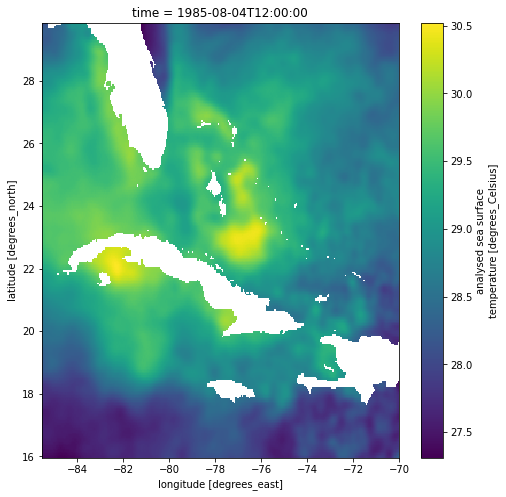

In [33]:
ds_slice.analysed_sst.isel(time=215).plot(figsize=(8,8))


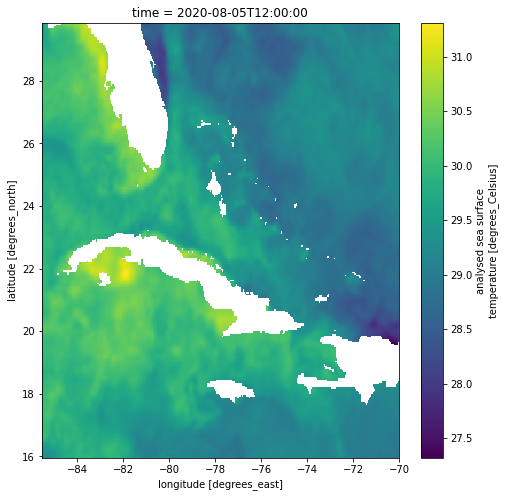

In [25]:
ds_slice.analysed_sst.isel(time=13000).plot(figsize=(8,8))


### We can also turn it into a pandas dataframe that more people are familiar with to do things like groupbys

Let's take a smaller time subset of the xarray

In [34]:
ds_slice =data.sel(lon=slice(-80,-78), lat=slice(20, 22), time=slice('2020-01-01', '2022-01-01'))
ds_slice

<xarray.Dataset>
Dimensions:           (time: 732, lat: 40, lon: 40)
Coordinates:
  * lat               (lat) float32 20.02 20.08 20.12 ... 21.88 21.92 21.98
  * lon               (lon) float32 -79.97 -79.93 -79.88 ... -78.07 -78.03
  * time              (time) datetime64[ns] 2020-01-01T12:00:00 ... 2022-01-0...
Data variables:
    analysed_sst      (time, lat, lon) float32 dask.array<chunksize=(1, 40, 40), meta=np.ndarray>
    crs               (time) int16 dask.array<chunksize=(31,), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float32 dask.array<chunksize=(1, 40, 40), meta=np.ndarray>
Attributes: (12/58)
    Conventions:                CF-1.6, ACDD-1.3
    acknowledgement:            NOAA Coral Reef Watch Program
    cdm_data_type:              Grid
    comment:                    This product is designed to improve on and re...
    contributor_name:           NOAA Coral Reef Watch Program
    contributor_role:           Collecting source data and deriving products;...
    ...                         ...
    time_coverage_duration:     P1D
    time_coverage_end:          19850102T000000Z
    time_coverage_resolution:   P1D
    time_coverage_start:        19850101T000000Z
    title:                      NOAA Coral Reef Watch Daily Global 5km Satell...
    uuid:                       36c339e6-c901-11e7-8a08-38d54702cff0

In [35]:
df = ds_slice.to_dataframe().reset_index() ## This can take some time depending on size of slice
df['time'] = pd.to_datetime(df['time'],format='%m/%d/%y %I:%M%p')
df['mnth_yr'] = df.time.dt.to_period('M').astype(str)


In [16]:
df.head()

,time,lat,lon,analysed_sst,crs,sea_ice_fraction,mnth_yr
0,1985-01-01 12:00:00,20.025,-79.974998,26.58,-32767,0.0,1985-01
1,1985-01-01 12:00:00,20.025,-79.925003,26.58,-32767,0.0,1985-01
2,1985-01-01 12:00:00,20.025,-79.875000,26.57,-32767,0.0,1985-01
3,1985-01-01 12:00:00,20.025,-79.824997,26.57,-32767,0.0,1985-01
4,1985-01-01 12:00:00,20.025,-79.775002,26.57,-32767,0.0,1985-01


### This is taking a lot of liberties of grouping this giant area together <br> Will be better when we have exat locations of reefs

In [17]:
df_plot = df.groupby(['mnth_yr']).agg({'analysed_sst': ['mean', 'min', 'max']}).reset_index()

In [18]:
df_plot

mnth_yr analysed_sst                      
                    mean        min        max
0   1985-01    25.343214  23.029999  26.629999
1   1985-02    25.436874  23.439999  27.219999
2   1985-03    25.737707  23.900000  26.820000
3   1985-04    26.387634  24.600000  27.309999
4   1985-05    27.827387  26.080000  29.619999
..      ...          ...        ...        ...
56  1989-09    29.575090  28.539999  30.539999
57  1989-10    29.114496  26.859999  30.389999
58  1989-11    27.986195  26.219999  29.670000
59  1989-12    26.898165  24.170000  28.809999
60  1990-01    25.771084  24.189999  26.680000

[61 rows x 4 columns]

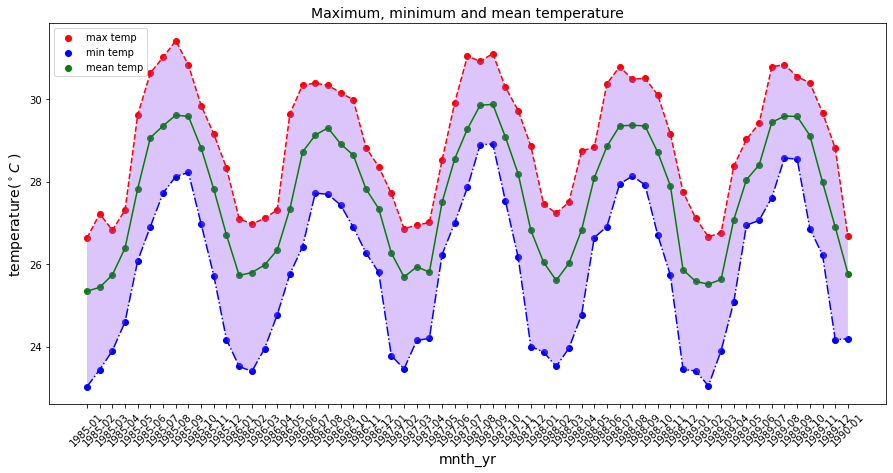

In [19]:
plt.figure(figsize=(15,7))

plt.plot(df_plot['mnth_yr'],df_plot['analysed_sst']['max'], '--r')
plt.plot(df_plot['mnth_yr'],df_plot['analysed_sst']['min'], '-.b')
plt.plot(df_plot['mnth_yr'],df_plot['analysed_sst']['mean'], 'g')
plt.scatter(df_plot['mnth_yr'],df_plot['analysed_sst']['max'],c='r',label='max temp')
plt.scatter(df_plot['mnth_yr'],df_plot['analysed_sst']['min'],c='b',label='min temp')
plt.scatter(df_plot['mnth_yr'],df_plot['analysed_sst']['mean'],c='g',label='mean temp')

plt.xlabel('mnth_yr',size=14)
plt.ylabel('temperature($^\circ C$ )',size=14)
plt.xticks(rotation = 45)
plt.xticks(df_plot['mnth_yr'])
ax=plt.gca()
# ax.axis([0,11,-40,40])
plt.gca().fill_between(df_plot['mnth_yr'], 
                       df_plot['analysed_sst']['max'], df_plot['analysed_sst']['min'], 
                       facecolor='#9D59F4', 
                       alpha=0.35)
plt.title('Maximum, minimum and mean temperature',size=14)
plt.legend(loc=0)

plt.show()


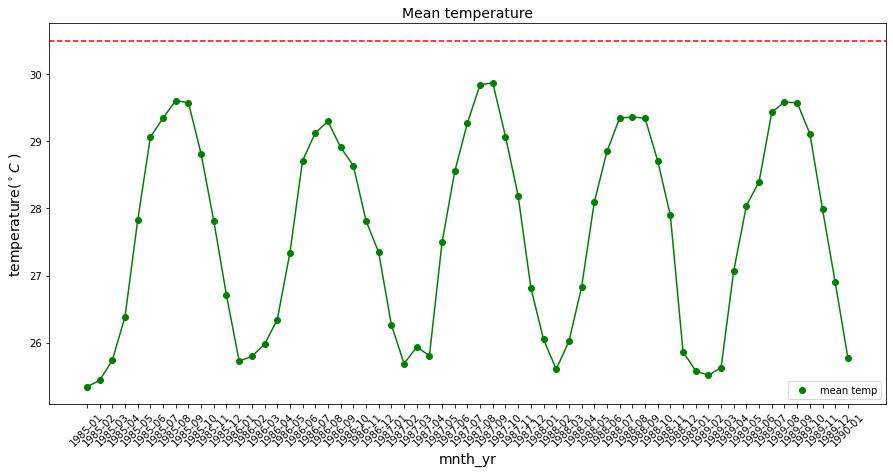

In [20]:
plt.figure(figsize=(15,7))


plt.plot(df_plot['mnth_yr'],df_plot['analysed_sst']['mean'], 'g')
plt.axhline(y =30.5, color = 'r', linestyle = '--')

plt.scatter(df_plot['mnth_yr'],df_plot['analysed_sst']['mean'],c='g',label='mean temp')


plt.xlabel('mnth_yr',size=14)
plt.ylabel('temperature($^\circ C$ )',size=14)
plt.xticks(rotation = 45)
plt.xticks(df_plot['mnth_yr'])
ax=plt.gca()
# ax.axis([0,11,-40,40])
# plt.gca().fill_between(df_plot['time'], 
#                        df_plot['analysed_sst']['max'], df_plot['analysed_sst']['min'], 
#                        facecolor='#9D59F4', 
#                        alpha=0.35)
plt.title('Mean temperature',size=14)
plt.legend(loc=0)

plt.show()
